In [15]:
from k1lib.imports import *

In [ ]:
class Network(nn.Module):
    def __init__(self, hiddenDim=10, hiddenLayers=2, relu=True):
        super().__init__()
        activation = lambda: nn.LeakyReLU() if relu else nn.Sigmoid()
        layers = []
        layers += [nn.Linear(1, hiddenDim), activation()]
        for i in range(hiddenLayers):
            layers += [nn.Linear(hiddenDim, hiddenDim), activation()]
        layers += [nn.Linear(hiddenDim, 1)]
        self.bulk = nn.Sequential(*layers)
    def forward(self, x):
        return self.bulk(x)

In [ ]:
def newL(lr=3e-5, momentum=0.9, bs=64):
    l = k1lib.Learner()
    l.model = Network(hiddenLayers=2)
    l.data = k1lib.data.Data.fromDataset(k1lib.data.FunctionDataset.exp, bs)
    l.opt = optim.SGD(l.model.parameters(), lr=lr, momentum=momentum)
    l.lossF = lambda x, y: ((x.squeeze() - y)**2).mean()
    #l.lossF = lambda x, y: (x**2).mean()
    l.cbs.withModifyBatch(lambda x, y: (x[:, None], y))
    l.cbs.withDType(torch.float32);
    def evaluate(self):
        xbs, ybs, ys = self.record(1, 3)
        xbs = torch.vstack(xbs).squeeze()
        ybs = torch.vstack([yb[:, None] for yb in ybs]).squeeze()
        ys = torch.vstack(ys).squeeze()
        #plt.plot(xbs, ybs, ".")
        plt.plot(xbs, ys.detach(), ".")
    l.evaluate = partial(evaluate, l)
    l.cbs.withCancelOnLowLoss(5, epochMode=True)
    #l.cbs.append(k1lib.Callback().withCheckpoint("endBatch", lambda self: k1lib.raiseEx(k1lib.CancelRunException)))
    return l

In [ ]:
bss = range(16, 64)
progresses = []
for bs in bss:
    for i in range(10):
        l = newL(bs=bs)
        l.remove("Autosave")
        l.run(10)
        progresses.append(l.progress)
with open("data.pth", "wb") as f:
    pickle.dump(k1lib.Object.fromDict({"bss": bss, "progresses": progresses}), f)

## Analysis

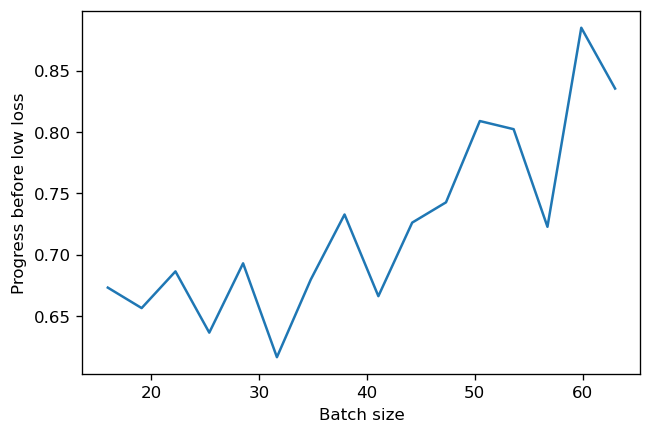

In [19]:
with open("data.pth", "rb") as f: data = pickle.load(f)
b = k1lib.smooth(data.progresses, 30)
a = np.linspace(data.bss[0], data.bss[-1], len(b))
plt.figure(dpi=120); plt.plot(a, b); plt.xlabel("Batch size"); plt.ylabel("Progress before low loss");